In [2]:
# necessary imports
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go # https://plot.ly/python/choropleth-maps/

# for enhanced plotting
# https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu
import plotly
import plotly.offline as offline
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# https://python-graph-gallery.com/292-choropleth-map-with-folium/
import folium

import time
import datetime
import json

init_notebook_mode(connected=True)

Remove from Data:
- Parish
- Borough
- County
- Municipality

In [3]:
# global properties
workDir = '/home/lefko/git/ut-health-project'

In [5]:
def loadIndicatorData(dir = '', idct = ''):
    df = pd.read_csv(workDir + '/data/' + dir + '/' + idct + '.csv')
    if 'geoId' in df.columns:
        df = df.drop(columns = ['geoId'], axis = 1) 
    
    return df

In [6]:


def plotOnUSMap(locs, values, title, maintext):
    '''
        needs a 'code' column in the dataframe (e.g. states) -> @param locs
    '''
    fig = go.Figure(data = go.Choropleth(
        locations = locs,
        z = values.astype(float),
        locationmode = 'USA-states',
        colorscale = 'Reds',
        colorbar_title = title
    ))

    fig.update_layout(
        title_text = maintext,
        geo_scope = 'usa', # limits map scope to USA
    )

    #fig.show()
    return fig

def genFoliumMap(title, state_data, cols, mapType = 'states', save = False, my_map=None, color='YlGn'):
    # colors: http://colorbrewer2.org/
    # Load the shape of the zone (US states)
    # Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
    # You have to download this file and set the directory where you saved it
    state_geo = os.path.join(workDir + '/data/', 'us-states.json')
    counties_geo = os.path.join(workDir + '/data/', 'us-counties.json')
    
    # Load the unemployment value of each state
    # Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
    #state_unemployment = os.path.join('./ut-health-project/data/', 'US_Unemployment_Oct2012.csv')
    #state_data = pd.read_csv(state_unemployment)
    
    # Initialize the map:
    if(my_map == None):
        m = folium.Map(location=[37, -102], zoom_start=5)
    else:
        print('adding a second layer')
        m = my_map
        
    if(mapType == 'states'):
        # Add the color for the chloropleth:
        folium.Choropleth(
            geo_data=json.load(open(state_geo)),
            #name='choropleth',
            data=state_data,
            columns=cols,
            key_on='feature.id',
            fill_color=color,
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name=title,
            nan_fill_color='White',
            marker_line_color='white',
            highlight=True,
            z = state_data['value'],
            #bins=bins
        ).add_to(m)
    elif(mapType == 'counties'):
        # https://www.fsanmartin.co/folium-choropleth-percentage-of-foreigners-by-us-county/
        folium.Choropleth(
            geo_data=json.load(open(counties_geo, encoding='ISO-8859-1')),
            #name='choropleth',
            data=state_data,
            columns=cols,
            key_on='properties.NAME',
            fill_color=color,
            fill_opacity=0.7,
            line_opacity=0.2,
            nan_fill_color='White',
            legend_name=title,
            #marker_line_color='white',
            highlight=True,
            z = state_data['value']
            #bins=bins
        ).add_to(m)

    #if(my_map != None):

    if(save == True):
        # Save to html
        #m.save(workDir + '/' + title +'_' + datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S') + '.html')
        #m.save(workDir + '/' + title + '.html')
        saveFinalMap(m, title)
    else:
        return m

def addLayerControl(m):
    folium.LayerControl(collapsed=False).add_to(m) # we're adding a second layer to the existing map
    return m

def saveFinalMap(m, title):
    m.save(workDir + '/' + title + '.html')

def plotOnUSMapWithSlider(df, title, maintext):
    data_slider = []
    steps = [] # slider steps
    years = df.year.unique()

    for year in years:
        df_per_year = df[(df.year == year)]
        data_of_year = dict(
            type = 'choropleth',
            locations = df_per_year['state_abbr'],
            z = df_per_year['value'].astype(float),
            colorscale = 'Reds',
            colorbar_title = title
        )

        data_slider.append(data_of_year)

    for i in range(len(data_slider)):
        step = dict(method='restyle',
                    args=['visible', [False] * len(data_slider)],
                    label='Year {}'.format(i + 2010)) # label to be displayed for each step (year)
        step['args'][1][i] = True
        steps.append(step)

    sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

    layout = dict(geo=dict(scope='usa'),
              sliders=sliders)

    # I create the figure object:
    fig = dict(data=data_slider, layout=layout) 

    return fig

In [36]:
# Life Expectancy, USA, Years: 2010, 2014
life_expectancy_total_1014 = loadIndicatorData('life-expectancy', 'life-expectancy')
life_expectancy_total_1014.head()

# Life Expectancy, USA, Years: 1900 - 2017
life_expectancy_total = loadIndicatorData('life-expectancy', 'life_expectancy_total')
#life_expectancy_total.head(25)

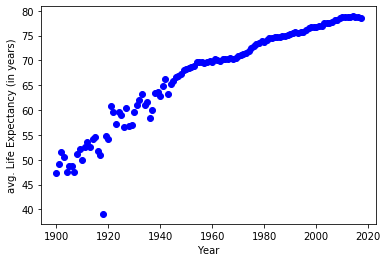

<Figure size 720x720 with 0 Axes>

In [6]:
plot_data = life_expectancy_total[(life_expectancy_total.Race == 'All Races') & (life_expectancy_total.Sex == 'Both Sexes')] 
plt.plot(plot_data['Year'], plot_data['Average Life Expectancy (Years)'], 'bo')
plt.ylabel('avg. Life Expectancy (in years)')
plt.xlabel('Year')
plt.figure(figsize=(10,10))
plt.show()

In [7]:
plot_data.tail(10)

,Year,Race,Sex,Average Life Expectancy (Years),Age-adjusted Death Rate
108,2008,All Races,Both Sexes,78.2,774.9
109,2009,All Races,Both Sexes,78.5,749.6
110,2010,All Races,Both Sexes,78.7,747.0
111,2011,All Races,Both Sexes,78.7,741.3
112,2012,All Races,Both Sexes,78.8,732.8
113,2013,All Races,Both Sexes,78.8,731.9
114,2014,All Races,Both Sexes,78.9,724.6
115,2015,All Races,Both Sexes,78.7,733.1
116,2016,All Races,Both Sexes,78.7,728.8
117,2017,All Races,Both Sexes,78.6,731.9


Volatile in the beginning (outlier: 1918), but since the 1950 the life expectancy increases (up until 2016), then it starts to decline a bit. As a side remark: in 2016 the global life expectancy was 72 years (WHO).
Let's check now for the LE within the USA.

In [37]:
# Average LE per area, Years: 2010, 2014
life_expectancy_total_1014_grouped = life_expectancy_total_1014.groupby(['metro_nonmetro', 'year'], as_index = False).mean()
life_expectancy_total_1014_grouped = life_expectancy_total_1014_grouped.append(pd.DataFrame({"metro_nonmetro":["USA", "USA"], "year":[2010, 2014], "value":[78.7, 78.9]}), ignore_index = True) # add data for USA total

life_expct_1014_per_state = life_expectancy_total_1014.groupby(['metro_nonmetro', 'state_abbr', 'year'], as_index=False).mean()

In [38]:
life_expectancy_total_1014_grouped

,metro_nonmetro,year,value
0,Metropolitan,2010,78.121184
1,Metropolitan,2014,78.227539
2,Nonmetropolitan,2010,77.449970
3,Nonmetropolitan,2014,77.469266
4,USA,2010,78.700000
5,USA,2014,78.900000


In [10]:
# Top 10 states per life expectancy
life_expct_1014_per_state[life_expct_1014_per_state.year == 2014].sort_values(by=['value'], ascending=[0])[0:10]

,metro_nonmetro,state_abbr,year,value
137,Nonmetropolitan,MA,2014,81.306667
23,Metropolitan,HI,2014,81.116667
47,Metropolitan,MN,2014,80.928519
115,Nonmetropolitan,CT,2014,80.740000
121,Nonmetropolitan,HI,2014,80.610000
11,Metropolitan,CO,2014,80.524118
13,Metropolitan,CT,2014,80.504286
79,Metropolitan,RI,2014,80.424000
145,Nonmetropolitan,MN,2014,80.402667
83,Metropolitan,SD,2014,80.313750


In [11]:
# Worst 10 states per life expectancy
life_expct_1014_per_state[life_expct_1014_per_state.year == 2014].sort_values(by=['value'], ascending=[0])[-10:]

,metro_nonmetro,state_abbr,year,value
169,Nonmetropolitan,OK,2014,75.359831
119,Nonmetropolitan,GA,2014,75.278235
107,Nonmetropolitan,AR,2014,75.270727
51,Metropolitan,MS,2014,74.979412
179,Nonmetropolitan,TN,2014,74.918679
133,Nonmetropolitan,KY,2014,74.723412
175,Nonmetropolitan,SC,2014,74.687500
135,Nonmetropolitan,LA,2014,74.482759
105,Nonmetropolitan,AL,2014,74.462368
149,Nonmetropolitan,MS,2014,74.184923


## Life Expectancy

In [17]:
# print as map
state_data = life_expct_1014_per_state[(life_expct_1014_per_state.year == 2014) & (life_expct_1014_per_state.metro_nonmetro == 'Nonmetropolitan')]
genFoliumMap(title = 'Life Expectancy per State (2014)', state_data = state_data, cols=['state_abbr', 'value'], save = True)

In [13]:
life_expct_1014_per_state.groupby(['metro_nonmetro', 'year'], as_index = False).mean()

,metro_nonmetro,year,value
0,Metropolitan,2010,78.523808
1,Metropolitan,2014,78.647840
2,Nonmetropolitan,2010,77.829050
3,Nonmetropolitan,2014,77.892211


Metropolitan areas are amongst the locations with the highest life expectancy (as of 2014), although NM areas in Massachussetts are, in total, the regions with the highest life expectancy. Hawaii follows second. More NM areas are having the lowest life expectancy, with NM in Mississippi are last. One thing which should be considered here is, that not all the states are equally sized or have the same amount of counties/inhabitants.

In [18]:
genFoliumMap(title='Life Expectancy per County (2014)', state_data=life_expectancy_total_2014_counties, cols = ['county_name', 'value'], mapType='counties', save = True)
# output won't show up here, so save it right away

In [40]:
# per state
m = genFoliumMap(title='Life Expectancy per state (2014)', state_data=life_expectancy_total_1014, cols = ['state_abbr', 'value'], mapType='states', color = 'Greens')

# per county
m = genFoliumMap(title='Life Expectancy per county (2014)', state_data=life_expectancy_total_1014, cols = ['county_name', 'value'], mapType='counties', my_map = m, color = 'Greens')

m = addLayerControl(m)
saveFinalMap(m, 'Life Expectancy (2014)')

adding a second layer


In [22]:
# only Metro areas
m = genFoliumMap(title='Life Expectancy per County (2014)(Metro)', state_data=life_expectancy_total_2014_counties[life_expectancy_total_2014_counties['metro_nonmetro'] == 'Metropolitan'], cols = ['county_name', 'value'], mapType='counties', save = False, color = 'BuPu')
# only Nonmetro areas
m = genFoliumMap(title='Life Expectancy per County (2014)(Nonmetro)', state_data=life_expectancy_total_2014_counties[life_expectancy_total_2014_counties['metro_nonmetro'] == 'Nonmetropolitan'], cols = ['county_name', 'value'], mapType='counties', save = False, my_map = m, color = 'GnBu')

m = addLayerControl(m)
saveFinalMap(m, 'Life Expectancy per County (2014) (Metro-Nonmetro)')

adding a second layer


## Diabetes/Obesity Prevalence

### Obesity

In [7]:
# load data
# the higher the value, the more inclinded are you to get diabetes
obesity_total_df = loadIndicatorData('obesity', 'obesity')
obesity_total_df['value'] = obesity_total_df['value'].apply(lambda x: x * 100)
obesity_total_df

,metro_nonmetro,year,county_name,state_abbr,value
0,Metropolitan,2006,Anchorage,AK,25.500058
1,Metropolitan,2006,Fairbanks North Star,AK,27.200134
2,Metropolitan,2006,Matanuska-Susitna,AK,28.300078
3,Metropolitan,2006,Autauga,AL,27.899907
4,Metropolitan,2006,Baldwin,AL,23.899944
...,...,...,...,...,...
34558,Nonmetropolitan,2016,Sweetwater,WY,29.500047
34559,Nonmetropolitan,2016,Teton,WY,12.300610
34560,Nonmetropolitan,2016,Uinta,WY,35.602316
34561,Nonmetropolitan,2016,Washakie,WY,28.701106


In [8]:
obesity_total_df.groupby(['metro_nonmetro', 'year'], as_index = False).mean()

,metro_nonmetro,year,value
0,Metropolitan,2006,26.914885
1,Metropolitan,2007,27.699958
2,Metropolitan,2008,28.391785
3,Metropolitan,2009,29.604215
4,Metropolitan,2010,29.751491
5,Metropolitan,2011,29.780940
6,Metropolitan,2012,29.911626
7,Metropolitan,2013,30.078431
8,Metropolitan,2014,30.405573
9,Metropolitan,2015,31.061003


In [9]:
# Worst 10 States per Obesity Prevalence
obesity_total_df[obesity_total_df.year == 2014].sort_values(by=['value'], ascending=[0])[0:10]

,metro_nonmetro,year,county_name,state_abbr,value
28726,Nonmetropolitan,2014,Macon,AL,48.001642
29620,Nonmetropolitan,2014,Claiborne,MS,46.506283
9357,Metropolitan,2014,Lowndes,AL,46.502425
29632,Nonmetropolitan,2014,Jefferson,MS,46.400142
30565,Nonmetropolitan,2014,Menominee,WI,45.300035
30599,Nonmetropolitan,2014,Mcdowell,WV,45.201939
9820,Metropolitan,2014,Somerset,MD,44.901961
10413,Metropolitan,2014,Petersburg City,VA,44.800859
28731,Nonmetropolitan,2014,Perry,AL,44.705882
28787,Nonmetropolitan,2014,St. Francis,AR,44.600800


In [10]:
# Top 10 States per Obesity Prevalence
obesity_total_df[obesity_total_df.year == 2014].sort_values(by=['value'], ascending=[0])[-10:]

,metro_nonmetro,year,county_name,state_abbr,value
10057,Metropolitan,2014,New York,NY,15.700009
28838,Nonmetropolitan,2014,Gunnison,CO,15.300637
28857,Nonmetropolitan,2014,Pitkin,CO,15.000000
28866,Nonmetropolitan,2014,Summit,CO,14.800049
30454,Nonmetropolitan,2014,Summit,UT,14.100121
9436,Metropolitan,2014,Boulder,CO,13.700042
28861,Nonmetropolitan,2014,Routt,CO,13.300596
10037,Metropolitan,2014,Santa Fe,NM,13.300000
30635,Nonmetropolitan,2014,Teton,WY,13.100507
28834,Nonmetropolitan,2014,Eagle,CO,12.700003


In [25]:
# per state
m = genFoliumMap(title='Obesity prevalence per state (2016)', state_data=obesity_total_df[obesity_total_df.year == 2016], cols = ['state_abbr', 'value'], mapType='states', save = False)

# per county
genFoliumMap(title='Obesity prevalence per county (2016)', state_data=obesity_total_df[obesity_total_df.year == 2016], cols = ['county_name', 'value'], mapType='counties', save = False, my_map = m)

m = addLayerControl(m)
saveFinalMap(m, 'Obesity prevalence (2016)')

adding a second layer


In [26]:
# metro
m = genFoliumMap(title='Obesity prevalence per county (2016)(Metro)', state_data=obesity_total_df[(obesity_total_df.year == 2016) & (obesity_total_df.metro_nonmetro == 'Metropolitan')], cols = ['county_name', 'value'], mapType='counties', save = False, color = 'BuPu')

# nonmetro
m = genFoliumMap(title='Obesity prevalence per county (2016)(Nonmetro)', state_data=obesity_total_df[(obesity_total_df.year == 2016) & (obesity_total_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value'], mapType='counties', save = False, my_map = m, color = 'GnBu')

m = addLayerControl(m)
saveFinalMap(m, 'Obesity prevalence (2016) (Metro-Nonmetro)')

adding a second layer


### Diabetes

In [11]:
# load data
# the higher the value, the more inclinded are you to get diabetes
diabetes_total_df = loadIndicatorData('diabetes', 'diabetes')
diabetes_total_df['value'] = diabetes_total_df['value'].apply(lambda x: x * 100)
diabetes_total_df

,metro_nonmetro,year,county_name,state_abbr,value
0,Metropolitan,2006,Anchorage,AK,5.500010
1,Metropolitan,2006,Fairbanks North Star,AK,4.500025
2,Metropolitan,2006,Matanuska-Susitna,AK,5.399961
3,Metropolitan,2006,Autauga,AL,11.400017
4,Metropolitan,2006,Baldwin,AL,9.100021
...,...,...,...,...,...
34554,Nonmetropolitan,2016,Sweetwater,WY,8.800153
34555,Nonmetropolitan,2016,Teton,WY,2.200000
34556,Nonmetropolitan,2016,Uinta,WY,11.300761
34557,Nonmetropolitan,2016,Washakie,WY,11.701065


In [12]:
diabetes_total_df.groupby(['metro_nonmetro', 'year'], as_index = False).mean()

,metro_nonmetro,year,value
0,Metropolitan,2006,8.869581
1,Metropolitan,2007,9.277417
2,Metropolitan,2008,9.570163
3,Metropolitan,2009,9.903204
4,Metropolitan,2010,10.253385
5,Metropolitan,2011,10.510448
6,Metropolitan,2012,10.661655
7,Metropolitan,2013,10.770983
8,Metropolitan,2014,10.910203
9,Metropolitan,2015,11.179261


In [13]:
# Worst 10 States per Obesity Prevalence
diabetes_total_df[diabetes_total_df.year == 2014].sort_values(by=['value'], ascending=[0])[0:10]

,metro_nonmetro,year,county_name,state_abbr,value
9348,Metropolitan,2014,Greene,AL,21.102214
28731,Nonmetropolitan,2014,Perry,AL,20.902512
28734,Nonmetropolitan,2014,Sumter,AL,20.401003
9357,Metropolitan,2014,Lowndes,AL,20.301037
30141,Nonmetropolitan,2014,Dillon,SC,20.100637
28738,Nonmetropolitan,2014,Wilcox,AL,20.000000
28726,Nonmetropolitan,2014,Macon,AL,19.800696
30598,Nonmetropolitan,2014,Mcdowell,WV,19.700732
30153,Nonmetropolitan,2014,Williamsburg,SC,19.600544
28704,Nonmetropolitan,2014,Bullock,AL,19.501325


In [14]:
# Top 10 States per Obesity Prevalence
diabetes_total_df[diabetes_total_df.year == 2014].sort_values(by=['value'], ascending=[0])[-10:]

,metro_nonmetro,year,county_name,state_abbr,value
28836,Nonmetropolitan,2014,Garfield,CO,4.700020
30634,Nonmetropolitan,2014,Teton,WY,4.500054
29686,Nonmetropolitan,2014,Gallatin,MT,4.400016
28838,Nonmetropolitan,2014,Gunnison,CO,4.300286
10365,Metropolitan,2014,Arlington,VA,4.300008
30453,Nonmetropolitan,2014,Summit,UT,4.300004
28866,Nonmetropolitan,2014,Summit,CO,4.200098
9436,Metropolitan,2014,Boulder,CO,4.000000
28861,Nonmetropolitan,2014,Routt,CO,3.800065
28834,Nonmetropolitan,2014,Eagle,CO,3.000000


In [30]:
# per state
m = genFoliumMap(title='Diabetes prevalence (in %) per State (2016)', state_data=diabetes_total_df[diabetes_total_df.year == 2016], cols = ['state_abbr', 'value'], mapType='states', color = 'Reds')

# per county
m = genFoliumMap(title='Diabetes prevalence (in %) per County (2016)', state_data=diabetes_total_df[diabetes_total_df.year == 2016], cols = ['county_name', 'value'], mapType='counties', my_map = m, color = 'Reds')

m = addLayerControl(m)
saveFinalMap(m, 'Diabetes prevalence (2016)')

adding a second layer


In [32]:
# metro
m = genFoliumMap(title='Diabetes prevalence (in %) per county (2016)(Metro)', state_data=diabetes_total_df[(diabetes_total_df.year == 2016) & (diabetes_total_df.metro_nonmetro == 'Metropolitan')], cols = ['county_name', 'value'], mapType='counties', color = 'BuPu')

# nonmetro
m = genFoliumMap(title='Diabetes prevalence per (in %) county (2016)(Nonmetro)', state_data=diabetes_total_df[(diabetes_total_df.year == 2016) & (diabetes_total_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value'], mapType='counties', color = 'Reds', my_map = m)

m = addLayerControl(m)
saveFinalMap(m, 'Diabetes prevalence (2016) (Metro-Nonmetro)')

adding a second layer


## Poverty/Education

### Poverty

In [15]:
# load data
# the higher the value, the poorer you are resp. is the ratio
poverty_total_df = loadIndicatorData('poverty-unemployment', 'poverty')
poverty_total_df['value'] = poverty_total_df['value'].apply(lambda x: x * 100)
poverty_total_df

,metro_nonmetro,year,county_name,state_abbr,value
0,Metropolitan,2009,Anchorage,AK,7.600000
1,Metropolitan,2009,Fairbanks North Star,AK,7.900004
2,Metropolitan,2009,Matanuska-Susitna,AK,8.699953
3,Metropolitan,2009,Autauga,AL,11.200048
4,Metropolitan,2009,Baldwin,AL,13.300032
...,...,...,...,...,...
28269,Nonmetropolitan,2017,Sweetwater,WY,10.000000
28270,Nonmetropolitan,2017,Teton,WY,5.800095
28271,Nonmetropolitan,2017,Uinta,WY,10.200355
28272,Nonmetropolitan,2017,Washakie,WY,10.700266


In [16]:
poverty_total_grouped_df = poverty_total_df.groupby(['metro_nonmetro', 'state_abbr', 'year'], as_index = False).mean()
poverty_total_grouped_df

,metro_nonmetro,state_abbr,year,value
0,Metropolitan,AK,2009,8.066652
1,Metropolitan,AK,2010,9.966636
2,Metropolitan,AK,2011,9.866633
3,Metropolitan,AK,2012,9.433322
4,Metropolitan,AK,2013,8.633318
...,...,...,...,...
877,Nonmetropolitan,WY,2013,11.138048
878,Nonmetropolitan,WY,2014,11.342735
879,Nonmetropolitan,WY,2015,10.490391
880,Nonmetropolitan,WY,2016,11.129224


In [17]:
# Worst 10 States per Obesity Prevalence
poverty_total_df[poverty_total_df.year == 2014].sort_values(by=['value'], ascending=[0])[0:10]

,metro_nonmetro,year,county_name,state_abbr,value
21912,Nonmetropolitan,2014,Shannon,SD,52.201524
21916,Nonmetropolitan,2014,Todd,SD,47.402070
21038,Nonmetropolitan,2014,McCreary,KY,46.998938
20427,Nonmetropolitan,2014,Perry,AL,46.901580
21050,Nonmetropolitan,2014,Owsley,KY,45.101159
21920,Nonmetropolitan,2014,Ziebach,SD,44.606104
21332,Nonmetropolitan,2014,Holmes,MS,43.999088
21077,Nonmetropolitan,2014,East Carroll,LA,42.997812
21323,Nonmetropolitan,2014,Claiborne,MS,42.598112
21949,Nonmetropolitan,2014,Lake,TN,41.898239


In [18]:
# Worst 10 States per Obesity Prevalence
poverty_total_df[poverty_total_df.year == 2014].sort_values(by=['value'], ascending=[0])[-10:]

,metro_nonmetro,year,county_name,state_abbr,value
6571,Metropolitan,2014,Delaware,OH,4.800000
6502,Metropolitan,2014,Hunterdon,NJ,4.700008
6836,Metropolitan,2014,Morgan,UT,4.599868
6701,Metropolitan,2014,Lincoln,SD,4.299984
21631,Nonmetropolitan,2014,Los Alamos,NM,4.200113
5930,Metropolitan,2014,Broomfield,CO,4.000000
6885,Metropolitan,2014,Loudoun,VA,3.899997
5933,Metropolitan,2014,Douglas,CO,3.700003
20391,Nonmetropolitan,2014,Skagway,AK,3.599222
6866,Metropolitan,2014,Falls Church city,VA,3.199883


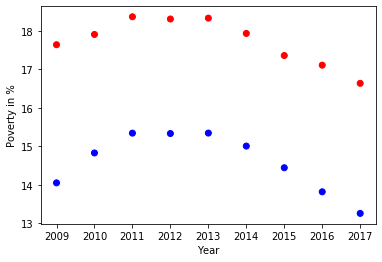

<Figure size 720x720 with 0 Axes>

In [40]:
poverty_total_grouped_df.metro_nonmetro = poverty_total_grouped_df.metro_nonmetro.apply(lambda x: 1 if x == 'Metropolitan' else 0)
colors = ['red', 'blue'] # blue: Metro, red: Nonmetro

plt.scatter(poverty_total_grouped_df['year'], poverty_total_grouped_df['value'], c=poverty_total_grouped_df.metro_nonmetro, cmap=matplotlib.colors.ListedColormap(colors))
plt.ylabel('Poverty in %')
plt.xlabel('Year')
plt.figure(figsize=(10,10))
plt.show()

In [19]:
# per state
m = genFoliumMap(title='Poverty (in %) per state (2014)', state_data=poverty_total_df[poverty_total_df.year == 2014], cols = ['state_abbr', 'value'], mapType='states', color = 'Blues')

# per county
m = genFoliumMap(title='Poverty (in %) per county (2014)', state_data=poverty_total_df[poverty_total_df.year == 2014], cols = ['county_name', 'value'], mapType='counties', my_map = m, color = 'Blues')

m = addLayerControl(m)
saveFinalMap(m, 'Poverty (in %) (2014)')

adding a second layer


In [20]:
# metro
m = genFoliumMap(title='Poverty (in %) per county (2014)(Metro)', state_data=poverty_total_df[(poverty_total_df.year == 2014) & (poverty_total_df.metro_nonmetro == 'Metropolitan')], cols = ['county_name', 'value'], mapType='counties', color = 'Purples')

# nonmetro
m = genFoliumMap(title='Poverty per (in %) county (2014)(Nonmetro)', state_data=poverty_total_df[(poverty_total_df.year == 2014) & (poverty_total_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value'], mapType='counties', my_map = m, color = 'RdPu')

m = addLayerControl(m)
saveFinalMap(m, 'Poverty (in %) (2014) (Metro-Nonmetro)')

adding a second layer


### Education

In [117]:
# load data
# the higher the value, the more people do not have a high school degree
education_total_df = loadIndicatorData('education', 'education')
education_total_df['value'] = education_total_df['value'].apply(lambda x: x * 100)
education_total_df

,metro_nonmetro,year,county_name,state_abbr,value
0,Metropolitan,2011,Anchorage,AK,7.900000
1,Metropolitan,2011,Fairbanks North Star,AK,7.000000
2,Metropolitan,2011,Matanuska-Susitna,AK,7.700000
3,Metropolitan,2011,Autauga,AL,13.600000
4,Metropolitan,2011,Baldwin,AL,12.200000
...,...,...,...,...,...
6280,Nonmetropolitan,2017,Sweetwater,WY,8.738069
6281,Nonmetropolitan,2017,Teton,WY,4.850659
6282,Nonmetropolitan,2017,Uinta,WY,8.221606
6283,Nonmetropolitan,2017,Washakie,WY,11.463628


In [118]:
education_total_grouped_df = education_total_df.groupby(['metro_nonmetro', 'year'], as_index = False).mean()
education_total_grouped_df

,metro_nonmetro,year,value
0,Metropolitan,2011,14.445330
1,Metropolitan,2017,12.161925
2,Nonmetropolitan,2011,17.423937
3,Nonmetropolitan,2017,14.782286


In [119]:
# per state
genFoliumMap(title='Without high school degree (in %) per state (2017)', state_data=education_total_df[education_total_df.year == 2017], cols = ['state_abbr', 'value'], mapType='states', save = True)

# per county
genFoliumMap(title='Without high school degree (in %) per county (2017)', state_data=education_total_df[education_total_df.year == 2017], cols = ['county_name', 'value'], mapType='counties', save = True)

# metro
genFoliumMap(title='Without high school degree (in %) per county (2017)(Metro)', state_data=education_total_df[(education_total_df.year == 2017) & (education_total_df.metro_nonmetro == 'Metropolitan')], cols = ['county_name', 'value'], mapType='counties', save = True)

# nonmetro
genFoliumMap(title='Without high school degree per (in %) county (2017)(Nonmetro)', state_data=education_total_df[(education_total_df.year == 2017) & (education_total_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value'], mapType='counties', save = True)

## Uninsured

In [28]:
# load data
# the higher the value, the more people do not have a high school degree
uninsured_total_df = loadIndicatorData('uninsured', 'uninsured')
uninsured_total_df['value'] = uninsured_total_df['value'].apply(lambda x: x * 100)
uninsured_total_df

,metro_nonmetro,year,county_name,state_abbr,value
0,Metropolitan,2008,Anchorage,AK,19.966750
1,Metropolitan,2008,Fairbanks North Star,AK,20.761554
2,Metropolitan,2008,Matanuska-Susitna,AK,27.309337
3,Metropolitan,2008,Autauga,AL,15.760383
4,Metropolitan,2008,Baldwin,AL,19.541640
...,...,...,...,...,...
34420,Nonmetropolitan,2017,Sweetwater,WY,16.940096
34421,Nonmetropolitan,2017,Teton,WY,17.517730
34422,Nonmetropolitan,2017,Uinta,WY,16.598500
34423,Nonmetropolitan,2017,Washakie,WY,19.335280


In [27]:
uninsured_total_grouped_df = uninsured_total_df.groupby(['metro_nonmetro', 'year'], as_index = False).mean()
uninsured_total_grouped_df

,metro_nonmetro,year,value
0,Metropolitan,2011,14.445330
1,Metropolitan,2017,12.161925
2,Nonmetropolitan,2011,17.423937
3,Nonmetropolitan,2017,14.782286


In [29]:
# Worst 10 States per Obesity Prevalence
uninsured_total_df[uninsured_total_df.year == 2014].sort_values(by=['value'], ascending=[0])[0:10]

,metro_nonmetro,year,county_name,state_abbr,value
7961,Metropolitan,2014,Hidalgo,TX,46.011224
7938,Metropolitan,2014,Cameron,TX,43.589030
26384,Nonmetropolitan,2014,Starr,TX,42.792949
8000,Metropolitan,2014,Webb,TX,41.529576
24639,Nonmetropolitan,2014,Aleutians East,AK,41.363145
26346,Nonmetropolitan,2014,Maverick,TX,39.866688
26258,Nonmetropolitan,2014,Castro,TX,39.476124
24664,Nonmetropolitan,2014,Yukon-Koyukuk Census Area,AK,39.400428
25032,Nonmetropolitan,2014,Clark,ID,39.344262
26366,Nonmetropolitan,2014,Presidio,TX,38.689674


In [30]:
# Top 10 States per Obesity Prevalence
uninsured_total_df[uninsured_total_df.year == 2014].sort_values(by=['value'], ascending=[0])[-10:]

,metro_nonmetro,year,county_name,state_abbr,value
7455,Metropolitan,2014,Berkshire,MA,4.701247
7454,Metropolitan,2014,Barnstable,MA,4.694378
25898,Nonmetropolitan,2014,Los Alamos,NM,4.605453
7459,Metropolitan,2014,Hampshire,MA,4.460905
7464,Metropolitan,2014,Worcester,MA,4.257100
7462,Metropolitan,2014,Plymouth,MA,4.160150
25365,Nonmetropolitan,2014,Franklin,MA,4.113288
7460,Metropolitan,2014,Middlesex,MA,3.812666
7461,Metropolitan,2014,Norfolk,MA,3.276437
7246,Metropolitan,2014,Kalawao,HI,0.000000


In [34]:
# per state
m = genFoliumMap(title='Uninsured (in %) per state (2014)', state_data=uninsured_total_df[uninsured_total_df.year == 2014], cols = ['state_abbr', 'value'], mapType='states', color = 'Blues')

# per county
m = genFoliumMap(title='Uninsured (in %) per county (2014)', state_data=uninsured_total_df[uninsured_total_df.year == 2014], cols = ['county_name', 'value'], mapType='counties', my_map = m, color = 'Blues')

m = addLayerControl(m)
saveFinalMap(m, 'Uninsured (in %) (2014)')

adding a second layer


In [32]:
# metro
m = genFoliumMap(title='Uninsured (in %) per county (2014)(Metro)', state_data=uninsured_total_df[(uninsured_total_df.year == 2014) & (uninsured_total_df.metro_nonmetro == 'Metropolitan')], cols = ['county_name', 'value'], mapType='counties', color = 'Purples')

# nonmetro
m = genFoliumMap(title='Uninsured per (in %) county (2014)(Nonmetro)', state_data=uninsured_total_df[(uninsured_total_df.year == 2014) & (uninsured_total_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value'], mapType='counties', my_map = m, color = 'RdPu')

m = addLayerControl(m)
saveFinalMap(m, 'Uninsured (in %) (2014) (Metro-Nonmetro)')

adding a second layer


## Medical Infrastructure
Divides into three categories: doctors per 10.000, physicians per 10.000 and the proportion of physicians under 35

In [5]:
medical_df = loadIndicatorData('medical-infrastructure', 'medical-infrastructure')
medical_df = medical_df[medical_df['value_real'] > .0] # to avoid problems with the means we remove counties with 0.0 values
medical_df

,metro_nonmetro,year,county_name,state_abbr,indicator,value,value_real
0,Metropolitan,2017,Anchorage,AK,doctors-per-10000,0.003526,35.261270
1,Metropolitan,2017,Fairbanks North Star,AK,doctors-per-10000,0.001900,18.995463
2,Metropolitan,2017,Matanuska-Susitna,AK,doctors-per-10000,0.000948,9.478673
3,Metropolitan,2017,Autauga,AL,doctors-per-10000,0.000683,6.834409
4,Metropolitan,2017,Baldwin,AL,doctors-per-10000,0.001913,19.126510
...,...,...,...,...,...,...,...
9421,Nonmetropolitan,2017,Sweetwater,WY,physicians-per-10000,0.001324,13.240111
9422,Nonmetropolitan,2017,Teton,WY,physicians-per-10000,0.004982,49.824531
9423,Nonmetropolitan,2017,Uinta,WY,physicians-per-10000,0.001232,12.315878
9424,Nonmetropolitan,2017,Washakie,WY,physicians-per-10000,0.000888,8.877616


In [6]:
medical_grouped_df = medical_df.groupby(['state_abbr', 'metro_nonmetro', 'indicator'], as_index = False).mean()
medical_grouped_df

,state_abbr,metro_nonmetro,indicator,year,value,value_real
0,AK,Metropolitan,doctors-per-10000,2017,0.002125,21.245135
1,AK,Metropolitan,physicians-per-10000,2017,0.002500,25.000498
2,AK,Metropolitan,physicians-under-35,2017,0.062366,6.236627
3,AK,Nonmetropolitan,doctors-per-10000,2017,0.001439,14.387542
4,AK,Nonmetropolitan,physicians-per-10000,2017,0.001553,15.529957
...,...,...,...,...,...,...
289,WY,Metropolitan,physicians-per-10000,2017,0.002612,26.116315
290,WY,Metropolitan,physicians-under-35,2017,0.068228,6.822778
291,WY,Nonmetropolitan,doctors-per-10000,2017,0.001268,12.682875
292,WY,Nonmetropolitan,physicians-per-10000,2017,0.001423,14.233232


In [7]:
# per state
my_map = genFoliumMap(title='Doctors per 10000 per state (2017)', state_data=medical_df[medical_df.indicator == 'doctors-per-10000'], cols = ['state_abbr', 'value_real'], mapType='states', save = False, color='BuGn')
my_map = genFoliumMap(title='Physicians under 35 per 100 per state (2017)', state_data=medical_df[medical_df.indicator == 'physicians-under-35'], cols = ['state_abbr', 'value_real'], mapType='states', save = False, my_map=my_map, color='BuPu')
my_map = genFoliumMap(title='Physicians per 10000 per state (2017)', state_data=medical_df[medical_df.indicator == 'physicians-per-10000'], cols = ['state_abbr', 'value_real'], mapType='states', save = False, my_map=my_map, color = 'OrRd')

my_map = addLayerControl(my_map)
saveFinalMap(my_map, 'Medical Access (2017)')

adding a second layer
adding a second layer


In [8]:
# per county
my_map = genFoliumMap(title='Doctors per 10000 per state (2017)', state_data=medical_df[medical_df.indicator == 'doctors-per-10000'], cols = ['county_name', 'value_real'], mapType='counties', save = False, color='BuGn')
my_map = genFoliumMap(title='Physicians under 35 per 100 per state (2017)', state_data=medical_df[medical_df.indicator == 'physicians-under-35'], cols = ['county_name', 'value_real'], mapType='counties', save = False, my_map=my_map, color='BuPu')
my_map = genFoliumMap(title='Physicians per 10000 per state (2017)', state_data=medical_df[medical_df.indicator == 'physicians-per-10000'], cols = ['county_name', 'value_real'], mapType='counties', save = False, my_map=my_map, color = 'OrRd')

my_map = addLayerControl(my_map)
saveFinalMap(my_map, 'Medical Access (2017) (County)')

adding a second layer
adding a second layer


In [10]:
# metro
m = genFoliumMap(title='Doctors per 10000 per County (2017) (Metro)', state_data=medical_df[(medical_df.indicator == 'doctors-per-10000') & (medical_df.metro_nonmetro == 'Metropolitan')], cols = ['county_name', 'value_real'], mapType='counties', color = 'BuGn')
m = genFoliumMap(title='Physicians under 35 per 100 per County (2017) (Metro)', state_data=medical_df[(medical_df.indicator == 'physicians-under-35') & (medical_df.metro_nonmetro == 'Metropolitan')], cols = ['county_name', 'value_real'], mapType='counties', save = False, my_map=m, color='BuPu')
m = genFoliumMap(title='Physicians per 10000 per County (2017) (Metro)', state_data=medical_df[(medical_df.indicator == 'physicians-per-10000') & (medical_df.metro_nonmetro == 'Metropolitan')], cols = ['county_name', 'value_real'], mapType='counties', save = False, my_map=m, color = 'OrRd')

m = addLayerControl(m)
saveFinalMap(m, 'Medical Access (2017) (County) (Metro)')

# nonmetro
#m = genFoliumMap(title='Without high school degree per (in %) county (2017)(Nonmetro)', state_data=education_total_df[(education_total_df.year == 2017) & (education_total_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value'], mapType='counties', save = True)

adding a second layer
adding a second layer


In [11]:
# metro
m = genFoliumMap(title='Doctors per 10000 per County (2017) (Nonmetro)', state_data=medical_df[(medical_df.indicator == 'doctors-per-10000') & (medical_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value_real'], mapType='counties', color = 'BuGn')
m = genFoliumMap(title='Physicians under 35 per 100 per County (2017) (Nonmetro)', state_data=medical_df[(medical_df.indicator == 'physicians-under-35') & (medical_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value_real'], mapType='counties', save = False, my_map=m, color='BuPu')
m = genFoliumMap(title='Physicians per 10000 per County (2017) (Nonmetro)', state_data=medical_df[(medical_df.indicator == 'physicians-per-10000') & (medical_df.metro_nonmetro == 'Nonmetropolitan')], cols = ['county_name', 'value_real'], mapType='counties', save = False, my_map=m, color = 'OrRd')

m = addLayerControl(m)
saveFinalMap(m, 'Medical Access (2017) (County) (Nonmetro)')

adding a second layer
adding a second layer


### That's it!